In [1]:
from __future__ import division
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline
dataset = pd.read_csv("../../creditcard.csv")
print(dataset)

            Time         V1         V2        V3        V4        V5  \
0            0.0  -1.359807  -0.072781  2.536347  1.378155 -0.338321   
1            0.0   1.191857   0.266151  0.166480  0.448154  0.060018   
2            1.0  -1.358354  -1.340163  1.773209  0.379780 -0.503198   
3            1.0  -0.966272  -0.185226  1.792993 -0.863291 -0.010309   
4            2.0  -1.158233   0.877737  1.548718  0.403034 -0.407193   
...          ...        ...        ...       ...       ...       ...   
284802  172786.0 -11.881118  10.071785 -9.834783 -2.066656 -5.364473   
284803  172787.0  -0.732789  -0.055080  2.035030 -0.738589  0.868229   
284804  172788.0   1.919565  -0.301254 -3.249640 -0.557828  2.630515   
284805  172788.0  -0.240440   0.530483  0.702510  0.689799 -0.377961   
284806  172792.0  -0.533413  -0.189733  0.703337 -0.506271 -0.012546   

              V6        V7        V8        V9  ...       V21       V22  \
0       0.462388  0.239599  0.098698  0.363787  ... -0.01830

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Perceptron
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

In [3]:
from neupy import algorithms, utils, init
from datetime import datetime

/home/gabriel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/gabriel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/gabriel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/gabriel/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:5

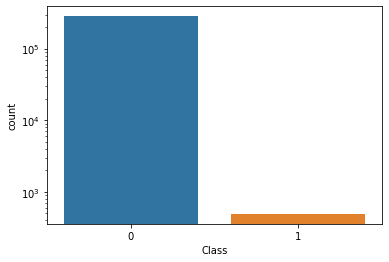

In [4]:
import seaborn as sn
ax=sn.countplot(x='Class',data=dataset);
ax.set_yscale('log')

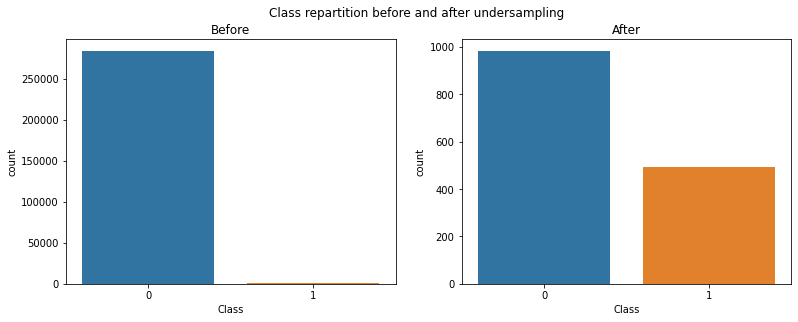

In [5]:
import imblearn
from imblearn.under_sampling import RandomUnderSampler 

undersample = RandomUnderSampler(sampling_strategy=0.5)

cols = dataset.columns.tolist()
cols = [c for c in cols if c not in ["Class"]]
target = "Class"

#define X and Y
X = dataset[cols]
Y = dataset[target]

#undersample
X_under, Y_under = undersample.fit_resample(X, Y)
test = pd.DataFrame(Y_under, columns = ['Class'])

fig, axs = plt.subplots(ncols=2, figsize=(13,4.5))
sn.countplot(x="Class", data=dataset, ax=axs[0])
sn.countplot(x="Class", data=test, ax=axs[1])

fig.suptitle("Class repartition before and after undersampling")
a1=fig.axes[0]
a1.set_title("Before")
a2=fig.axes[1]
a2.set_title("After")

dataset = pd.concat([X_under, Y_under], axis=1)

In [6]:
from pandas import DataFrame

# Data preprocessing
train_size = 0.75
test_size = 1 - train_size
train, test = train_test_split(dataset, test_size = test_size)
patterns_input = train.iloc[:,1:30].values[:]
input_test = test.iloc[:,1:30].values[:]

patterns_target = train.iloc[:,-1].values[:]
target_test = test['Class'].values[:]

input_train, input_valid, target_train, target_valid = train_test_split(
    patterns_input, patterns_target, train_size=train_size, test_size=test_size,
    random_state=0, shuffle=True)

print(input_train.shape, target_train.shape)
print(input_valid.shape, target_valid.shape)

(830, 29) (830,)
(277, 29) (277,)


In [7]:
# Modeling SOM
# ------------
max_iter_som = 55
grid_height = 20
grid_width = 20
distance = 'euclid'
learning_radius = 5
step = 0.5
reduce_step_after = max_iter_som - 5
std = 1.0
reduce_std_after = max_iter_som - 5
weight = init.Normal()

print("Learning %dx%d SOM with %d maximum number of iterations and ..." % (grid_height, grid_width, max_iter_som))

now = datetime.now()
# Random generator seed for NeuPy
utils.reproducible(0)

sofm = algorithms.SOFM(
    n_inputs = input_train.shape[1],
    features_grid = (grid_height, grid_width),
    distance = distance,
    weight = weight,
    learning_radius = learning_radius,
    reduce_radius_after = max_iter_som // learning_radius,  # 0 radius at end
    step = step,
    reduce_step_after = reduce_step_after,
    std = std,
    reduce_std_after = reduce_std_after,
    shuffle_data = False,
    verbose = True,
)

sofm.train(input_train, epochs=max_iter_som)
sofm_output_train = sofm.predict(input_train)
sofm_output_valid = sofm.predict(input_valid)
print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())

Learning 20x20 SOM with 55 maximum number of iterations and ...

Main information

[ALGORITHM] SOFM

[OPTION] distance = ['euclid', 'neg_euclid_distance']
[OPTION] features_grid = [20, 20]
[OPTION] grid_type = ['rectangle', 'find_neighbours_on_rect_grid', 'find_step_scaler_on_rect_grid']
[OPTION] learning_radius = 5
[OPTION] n_inputs = 29
[OPTION] n_outputs = None
[OPTION] reduce_radius_after = 11
[OPTION] reduce_std_after = 50
[OPTION] reduce_step_after = 50
[OPTION] show_epoch = 1
[OPTION] shuffle_data = False
[OPTION] signals = None
[OPTION] std = 1.0
[OPTION] step = 0.5
[OPTION] verbose = True
[OPTION] weight = Normal(mean=0, std=0.01)

#1 : [219 ms] train: 3.137579
#2 : [229 ms] train: 2.812118
#3 : [201 ms] train: 2.757655
#4 : [215 ms] train: 2.758706
#5 : [205 ms] train: 2.784074
#6 : [201 ms] train: 2.760845
#7 : [206 ms] train: 2.764320
#8 : [201 ms] train: 2.712939
#9 : [192 ms] train: 2.717454
#10 : [182 ms] train: 2.703746
#11 : [185 ms] train: 2.355191
#12 : [179 ms] trai

Building visualization of prototypes grid ...
Progress: 0.00%
Progress: 5.00%
Progress: 10.00%
Progress: 15.00%
Progress: 20.00%
Progress: 25.00%
Progress: 30.00%
Progress: 35.00%
Progress: 40.00%
Progress: 45.00%
Progress: 50.00%
Progress: 55.00%
Progress: 60.00%
Progress: 65.00%
Progress: 70.00%
Progress: 75.00%
Progress: 80.00%
Progress: 85.00%
Progress: 90.00%
Progress: 95.00%


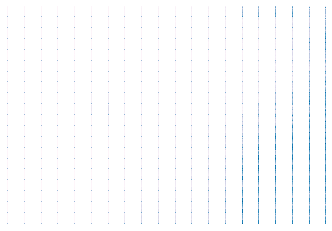

In [21]:
def plot_prototypes_grid(grid_height, grid_width, weight):
    """
    Visualization prototypes of SOM grid
    """
    print("Building visualization of prototypes grid ...")
    grid = gridspec.GridSpec(grid_height, grid_width)
    grid.update(wspace=0, hspace=0)
    for row_id in range(grid_height):
        print("Progress: {:.2%}".format(row_id / grid_height))
        for col_id in range(grid_width):
            index = row_id * grid_width + col_id
            sample = weight[:,index]
            _ = plt.subplot(grid[index])
            _ = plt.imshow(sample.reshape((29, 1)), cmap='PuBu')
            _ = plt.axis('off')
    plt.show()

plot_prototypes_grid(grid_height, grid_width, sofm.weight)

In [22]:
max_iter_per = 30

print("Learning a Perceptron with %d maximum number of iterations and ..." % max_iter_per)

per = Perceptron(max_iter=max_iter_per, shuffle=False, random_state=0, verbose=True)
per.fit(sofm_output_train, target_train)


# Intitial results
# ------------
print("Printing initial results")

predict_train = per.predict(sofm_output_train)
predict_valid = per.predict(sofm_output_valid)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))

Learning a Perceptron with 30 maximum number of iterations and ...
-- Epoch 1
Norm: 21.73, NNZs: 247, Bias: 0.000000, T: 830, Avg. loss: 0.166265
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 26.12, NNZs: 275, Bias: 0.000000, T: 1660, Avg. loss: 0.059036
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 28.46, NNZs: 284, Bias: 0.000000, T: 2490, Avg. loss: 0.055422
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 29.75, NNZs: 286, Bias: 1.000000, T: 3320, Avg. loss: 0.061446
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 30.74, NNZs: 288, Bias: 1.000000, T: 4150, Avg. loss: 0.067470
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 31.56, NNZs: 288, Bias: 0.000000, T: 4980, Avg. loss: 0.065060
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 32.08, NNZs: 288, Bias: 1.000000, T: 5810, Avg. loss: 0.072289
Total training time: 0.01 seconds.
-- Epoch 8
Norm: 32.66, NNZs: 288, Bias: 1.000000, T: 6640, Avg. loss: 0.071084
Total training time: 0.01 seconds.
Convergence af

In [23]:
print("Architecture optimization")

# Test SOM with differents number of grid units and several repetitions
tests_grid_side = [5, 10, 15, 20, 25, 30, 35]
n_reps = 5

now = datetime.now()
best_sofm = []
best_per = []
best_acc = 0.0
accs_train = []
accs_valid = []
for grid_side in tests_grid_side:
    max_acc_train = max_acc_valid = 0.0
    for random_state in range(n_reps):
        utils.reproducible(random_state)
        sofm = algorithms.SOFM(n_inputs = input_train.shape[1], features_grid = (grid_side, grid_side), distance = distance, weight = weight, learning_radius = learning_radius, reduce_radius_after = max_iter_som // learning_radius, step = step, reduce_step_after = reduce_step_after, std = std, reduce_std_after = reduce_std_after, shuffle_data = False, verbose = False)
        sofm.train(input_train, epochs=max_iter_som)
        sofm_output_train = sofm.predict(input_train)
        sofm_output_valid = sofm.predict(input_valid)
        per = Perceptron(max_iter=max_iter_per, shuffle=False, random_state=random_state, verbose=False)
        _ = per.fit(sofm_output_train, target_train)
        acc_train = accuracy_score(target_train, per.predict(sofm_output_train))
        acc_valid = accuracy_score(target_valid,per.predict(sofm_output_valid))
        print("Seed = %d, train acc = %.8f, valid acc = %.8f" % (random_state, acc_train, acc_valid))
        if (max_acc_valid < acc_valid):
            max_acc_valid = acc_valid
            max_acc_train = acc_train
            if (acc_valid > best_acc):
                best_acc = acc_valid
                best_per = per
                best_sofm = sofm
    accs_train.append(max_acc_train)
    accs_valid.append(max_acc_valid)
    print("Grid size = %ix%i, train acc = %.8f, max valid acc = %.8f" % (grid_side, grid_side, max_acc_train, max_acc_valid))

print("Number of seconds for training: %d" % (datetime.now() - now).total_seconds())
print("Best CPN valid accuracy: %.8f%%" % (best_acc * 100))
print("Best SOM: ", best_sofm)
print("Best Perceptron: ", best_per)

Architecture optimization
Seed = 0, train acc = 0.85542169, valid acc = 0.81949458
Seed = 1, train acc = 0.85542169, valid acc = 0.81949458
Seed = 2, train acc = 0.85542169, valid acc = 0.81949458
Seed = 3, train acc = 0.85542169, valid acc = 0.81949458
Seed = 4, train acc = 0.85542169, valid acc = 0.81949458
Grid size = 5x5, train acc = 0.85542169, max valid acc = 0.81949458
Seed = 0, train acc = 0.87349398, valid acc = 0.84476534
Seed = 1, train acc = 0.85060241, valid acc = 0.80144404
Seed = 2, train acc = 0.78795181, valid acc = 0.78339350
Seed = 3, train acc = 0.90240964, valid acc = 0.88086643
Seed = 4, train acc = 0.77590361, valid acc = 0.76173285
Grid size = 10x10, train acc = 0.90240964, max valid acc = 0.88086643
Seed = 0, train acc = 0.90602410, valid acc = 0.90613718
Seed = 1, train acc = 0.90240964, valid acc = 0.86642599
Seed = 2, train acc = 0.91927711, valid acc = 0.89169675
Seed = 3, train acc = 0.89879518, valid acc = 0.87725632
Seed = 4, train acc = 0.90602410, vali

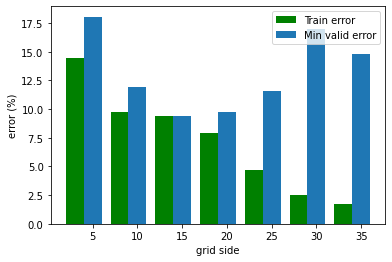

In [24]:
width = 2
plt.bar(np.array(tests_grid_side) - width, 100 *(1- np.array(accs_train)), color='g', width=width, label='Train error')
plt.bar(np.array(tests_grid_side), 100 *(1- np.array(accs_valid)), width=width, label='Min valid error')
plt.xlabel('grid side')
plt.ylabel('error (%)')
plt.xticks(np.array(tests_grid_side), tests_grid_side)
plt.legend(loc='upper right')
plt.show()


In [60]:
print("Printing final results")

sofm_output_train = best_sofm.predict(input_train)
sofm_output_valid = best_sofm.predict(input_valid)
sofm_output_test = best_sofm.predict(input_test)
predict_train = best_per.predict(sofm_output_train)
predict_valid = best_per.predict(sofm_output_valid)
predict_test = best_per.predict(sofm_output_test)

print("Train accuracy: %.3f%%" % (accuracy_score(target_train, predict_train) * 100))
print("Valid accuracy: %.3f%%" % (accuracy_score(target_valid, predict_valid) * 100))
print("Test accuracy: %.3f%%" % (accuracy_score(target_test, predict_test) * 100))

print("Train confusion matrix:")
print(confusion_matrix(target_train, predict_train))
print("Valid confusion matrix:")
print(confusion_matrix(target_valid, predict_valid))
print("Test confusion matrix:")
print(confusion_matrix(target_test, predict_test))

print("Train classification report:")
print(classification_report(target_train, predict_train))
print("Valid classification report:")
print(classification_report(target_valid, predict_valid))
print("Test classification report:")
print(classification_report(target_test, predict_test))

Printing final results
Train accuracy: 90.602%
Valid accuracy: 90.614%
Test accuracy: 84.824%
Train confusion matrix:
[[495  60]
 [ 18 257]]
Valid confusion matrix:
[[162  18]
 [  8  89]]
Test confusion matrix:
[[203  46]
 [ 10 110]]
Train classification report:
              precision    recall  f1-score   support

           0       0.96      0.89      0.93       555
           1       0.81      0.93      0.87       275

    accuracy                           0.91       830
   macro avg       0.89      0.91      0.90       830
weighted avg       0.91      0.91      0.91       830

Valid classification report:
              precision    recall  f1-score   support

           0       0.95      0.90      0.93       180
           1       0.83      0.92      0.87        97

    accuracy                           0.91       277
   macro avg       0.89      0.91      0.90       277
weighted avg       0.91      0.91      0.91       277

Test classification report:
              precision   

In [71]:
# ROC curves of test set
per_probs = best_per.decision_function(sofm_output_test)
classes  = np.unique(target_train)
per_auc = []
per_fpr = []
per_tpr = []
print(per_probs)
for cla in classes:
   per_auc.append(roc_auc_score(target_test==cla, per_probs[:,cla]))
   fpr, tpr, _ = roc_curve(target_test==cla, per_probs[:,cla])
   per_fpr.append(fpr)
   per_tpr.append(tpr)

print("Printing ROC curves of test set")
# plot the roc curve for the model
for cla in classes:
   # plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
   _ = plt.plot(per_fpr[cla], per_tpr[cla], marker='.', label='Class %d (AUC: %.5f)' % (cla, per_auc[cla]))

# axis labels
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

# Show grid prototypes
plot_prototypes_grid(best_sofm.features_grid[0], best_sofm.features_grid[1], best_sofm.weight)

# Show errors on real class 8
real_class = 8
indxs = np.where(digits_test.target == real_class)[0]
indxs_err = indxs[(np.where(predict_test[(indxs)] != real_class)[0])]
preds_err = predict_test[(indxs_err)]
n_img_plt = 8

print("Showing first %d errors of real class %d" % (n_img_plt, real_class))

_, axes = plt.subplots(2, n_img_plt//2)
images_and_labels = list(zip(digits_test.images[(indxs_err)], digits_test.target[(indxs_err)], preds_err))
for ax, (image, label1, label2) in zip(np.concatenate(axes), images_and_labels):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation='nearest')
    ax.set_title('real:%i pred:%i' % (label1, label2))

plt.show()

[ 0. -2.  4.  0.  0. -1. -1.  1.  2.  2.  0. -2.  3.  4.  4.  0.  5. -2.
 -2.  3.  2.  0. -1.  4.  0.  3.  0.  2.  0. -1. -2. -1.  2. -1.  0. -1.
  0. -2. -1.  0.  3.  1. -1.  4. -1. -1. -1.  3. -1.  3.  1. -1.  2. -2.
  0.  5.  3.  4. -1. -2. -2.  5.  0. -1.  2.  4.  4.  2.  0. -1.  0.  0.
 -2. -1.  0.  5.  0.  2. -1. -1.  1.  4.  0.  4.  2.  0.  0.  4.  0. -1.
 -1. -1.  2.  2.  0. -1.  1. -1.  0.  1.  2.  4.  2. -1.  2. -1. -1. -1.
 -2. -1.  5. -1.  4.  0.  5.  0.  2. -1.  1.  5. -1.  2. -2.  4.  0.  4.
  3. -1. -2.  0.  0.  4. -1.  0.  3.  4.  0.  4.  2. -1.  1.  0.  5.  2.
  3.  1.  4. -1.  0.  0. -1.  5. -1.  2.  5. -2.  0.  0.  1.  3.  1.  0.
  2.  1.  2.  2.  0. -1.  0.  4.  2.  0.  4. -1.  0.  4. -2.  0.  5.  1.
 -2.  0.  0. -1.  2. -1.  0. -1.  2.  4. -1. -2.  0.  1.  1. -1. -1.  3.
 -2. -1. -1.  4.  4. -2.  1. -1.  3.  2.  3.  1.  0. -1. -1.  2.  0.  0.
 -1. -1.  4.  0.  0. -1.  2. -2.  2.  1. -2.  0.  0.  0. -1.  0.  0. -1.
  1.  0.  2.  4.  0.  4. -2. -1. -1.  3. -1.  0. -2

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed